<a href="https://colab.research.google.com/github/alexandrastna/AI-for-ESG/blob/main/Notebooks/8_2_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Thesis 8 - Model Benchmarking on ESG and Sentiment Classification


Step 2 - In this step, we evaluate the performance of multiple models on a human-annotated sample of 150 sentences.
We compare:
1. ESG classification from our fine-tuned ESG-BERT model ("label_dominant")
2. Sentiment classification from FinBERT ("sentiment_finbert")
3. Sentiment classification from GPT-3.5 ("sentiment_gpt_batch")
4. ESG classification using GPT-3.5 with a prompt-based method ("esg_gpt3")


The manually labeled columns ("esg_label_humain" and "sentiment_humain") serve as the ground truth.
Additional visualizations (confusion matrix) and example errors are shown to interpret results.

### Imports and first evaluation function


In [2]:
# Imports
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# 📂 Mount Google Drive
drive.mount('/content/drive')

# Load input files
sentiment_source_path = "/content/drive/MyDrive/Thèse Master/Exports2/df_esg_with_sentiment.csv"
gold_path = "/content/drive/MyDrive/Thèse Master/Exports2/2df_gold_standard_final_150.xlsx"

# Load both datasets
df_sentiment = pd.read_csv(sentiment_source_path)
df_gold = pd.read_excel(gold_path)

# Merge FinBERT sentiment scores from the reference dataset
df_merged = df_gold.merge(
    df_sentiment[["sentence", "sent_label"]],
    on="sentence",
    how="left"
)

df_sentiment_clean = df_sentiment.drop_duplicates(subset="sentence")

df_merged = df_gold.merge(
    df_sentiment_clean[["sentence", "sent_label"]],
    on="sentence",
    how="left"
)


# Rename for clarity
df_merged = df_merged.rename(columns={"sent_label": "sentiment_finbert"})

# Sanity check
print("✅ Merge completed. DataFrame size: :", df_merged.shape)
print(df_merged[["sentence", "sentiment_humain", "sentiment_finbert", "sentiment_gpt_batch", "esg_label_humain", "label_dominant"]].head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Merge completed. DataFrame size: : (150, 15)
                                            sentence sentiment_humain  \
0  Our approach goes hand-in-hand with  our ABB v...          neutral   
1  Drawing on ABB’s 130 years of experience in th...          neutral   
2  Both personal goals and group wide  goals (fin...          neutral   
3  Strategic:  Strategic risks can relate to any ...          neutral   
4  GRI 406 - Non-discrimination 406-1 Total numbe...         negative   

  sentiment_finbert sentiment_gpt_batch esg_label_humain label_dominant  
0           neutral            positive           social         social  
1          positive            positive    environmental  environmental  
2           neutral             neutral       governance         social  
3          negative             neutral       governance  environmental  
4           neu

In [3]:
print("Number of rows in df_gold:", df_gold.shape[0])
print("Number of unique sentences in df_gold:", df_gold["sentence"].nunique())

Number of rows in df_gold: 150
Number of unique sentences in df_gold: 150


In [4]:
# Utility function to evaluate a classification model
def evaluate_classification(y_true, y_pred, title):
    print(f"\n🎯 Accuracy on {title}: {accuracy_score(y_true, y_pred):.2%}\n")
    print(f"📋 Classification report on {title}:\n")
    print(classification_report(y_true, y_pred))
    print(f"🧩 Confusion Matrix on {title}:")
    cm = confusion_matrix(y_true, y_pred, labels=sorted(set(y_true) | set(y_pred)))
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=sorted(set(y_true) | set(y_pred)), yticklabels=sorted(set(y_true) | set(y_pred)))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix – {title}")
    plt.show()

### Test 1: ESG Classification – ESGBERT vs Human


🎯 Accuracy on ESG Classification (ESGBERT vs Human): 85.33%

📋 Classification report on ESG Classification (ESGBERT vs Human):

               precision    recall  f1-score   support

environmental       0.91      0.97      0.94        72
   governance       1.00      0.70      0.82        50
         none       0.00      0.00      0.00         4
       social       0.61      0.96      0.74        24

     accuracy                           0.85       150
    macro avg       0.63      0.66      0.63       150
 weighted avg       0.87      0.85      0.84       150

🧩 Confusion Matrix on ESG Classification (ESGBERT vs Human):


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


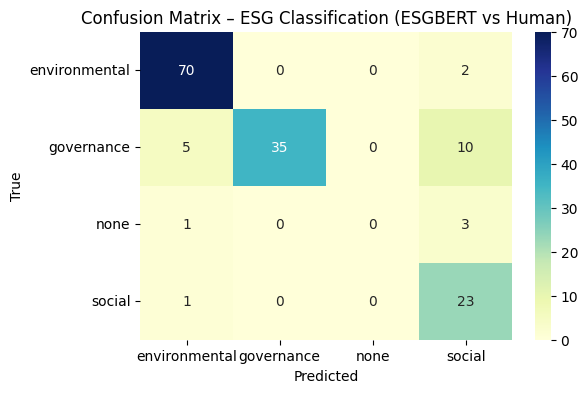

In [5]:
# 1.1: ESG Classification – label_dominant vs esg_label_humain
evaluate_classification(
    y_true=df_merged["esg_label_humain"],
    y_pred=df_merged["label_dominant"],
    title="ESG Classification (ESGBERT vs Human)"
)



🎯 Accuracy on ESG Classification (ESGBERT vs Human, without 'none'): 87.67%

📋 Classification report on ESG Classification (ESGBERT vs Human, without 'none'):

               precision    recall  f1-score   support

environmental       0.92      0.97      0.95        72
   governance       1.00      0.70      0.82        50
       social       0.66      0.96      0.78        24

     accuracy                           0.88       146
    macro avg       0.86      0.88      0.85       146
 weighted avg       0.90      0.88      0.88       146

🧩 Confusion Matrix on ESG Classification (ESGBERT vs Human, without 'none'):


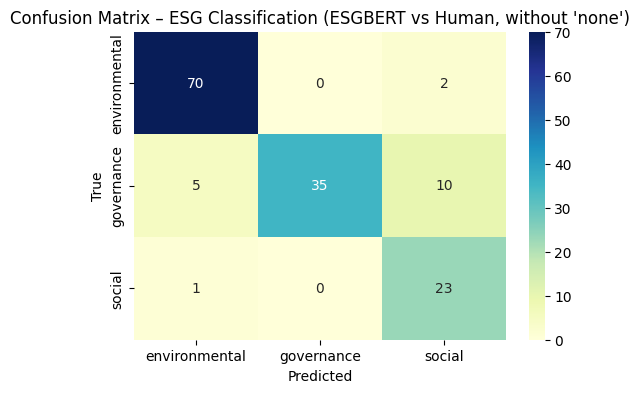

In [6]:
# 1.2 : Remove 'none' from human labels
df_filtered = df_merged[df_merged["esg_label_humain"] != "none"].copy()

# ESG Classification without 'none' class
labels_esg = ["environmental", "governance", "social"]

def evaluate_classification_filtered(y_true, y_pred, title, labels):
    print(f"\n🎯 Accuracy on {title}: {accuracy_score(y_true, y_pred):.2%}\n")
    print(f"📋 Classification report on {title}:\n")
    print(classification_report(y_true, y_pred, labels=labels))
    print(f"🧩 Confusion Matrix on {title}:")
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix – {title}")
    plt.show()

evaluate_classification_filtered(
    y_true=df_filtered["esg_label_humain"],
    y_pred=df_filtered["label_dominant"],
    title="ESG Classification (ESGBERT vs Human, without 'none')",
    labels=labels_esg
)


### Test 2 : Sentiment – FinBERT vs Human


🎯 Accuracy on Sentiment Analysis (FinBERT vs Human): 60.67%

📋 Classification report on Sentiment Analysis (FinBERT vs Human):

              precision    recall  f1-score   support

    negative       0.46      0.79      0.58        14
     neutral       0.66      0.74      0.70        90
    positive       0.54      0.28      0.37        46

    accuracy                           0.61       150
   macro avg       0.55      0.60      0.55       150
weighted avg       0.60      0.61      0.59       150

🧩 Confusion Matrix on Sentiment Analysis (FinBERT vs Human):


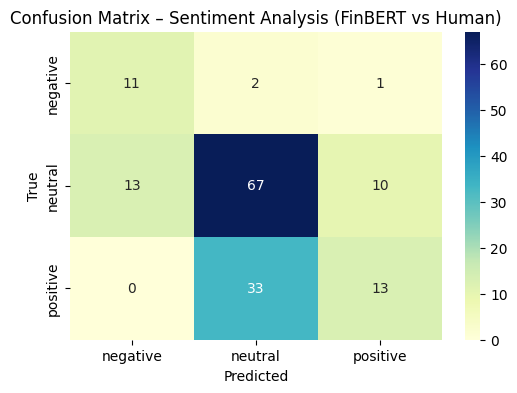

In [ ]:
# Sentiment – FinBERT vs Human
evaluate_classification(
    y_true=df_merged["sentiment_humain"],
    y_pred=df_merged["sentiment_finbert"],
    title="Sentiment Analysis (FinBERT vs Human)"
)



### Test 3 : Sentiment - GPT 3.5 vs Human


🎯 Accuracy on Sentiment Analysis (GPT-3.5 vs Human): 72.67%

📋 Classification report on Sentiment Analysis (GPT-3.5 vs Human):

              precision    recall  f1-score   support

    negative       0.36      1.00      0.53        14
     neutral       0.95      0.58      0.72        90
    positive       0.77      0.93      0.84        46

    accuracy                           0.73       150
   macro avg       0.69      0.84      0.70       150
weighted avg       0.84      0.73      0.74       150

🧩 Confusion Matrix on Sentiment Analysis (GPT-3.5 vs Human):


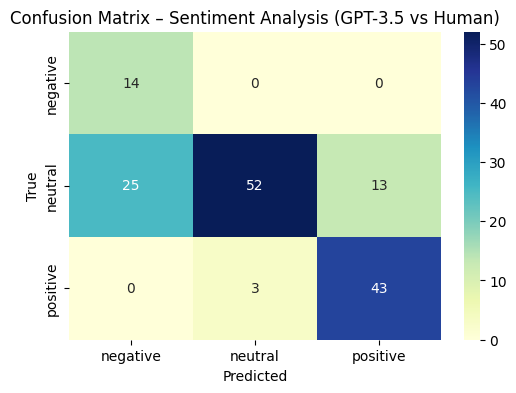

In [ ]:
# Sentiment – GPT 3.5 vs Human
evaluate_classification(
    y_true=df_merged["sentiment_humain"],
    y_pred=df_merged["sentiment_gpt_batch"],
    title="Sentiment Analysis (GPT-3.5 vs Human)"
)



### Extra : Display examples of misclassifications

In [ ]:
# Extra : Display examples of misclassifications

def display_errors(df, col_pred, col_true, title, n=5):
    errors = df[df[col_pred] != df[col_true]]
    print(f"\n❌ {len(errors)} misclassified – {title}")
    display(errors[[col_true, col_pred, "sentence"]].sample(n=min(n, len(errors)), random_state=42))

# ESG misclassifications
display_errors(df_merged, "label_dominant", "esg_label_humain", "ESG Classification")

# FinBERT misclassifications
display_errors(df_merged, "sentiment_finbert", "sentiment_humain", "Sentiment – FinBERT")

# GPT-3.5 misclassifications
display_errors(df_merged, "sentiment_gpt_batch", "sentiment_humain", "Sentiment – GPT 3.5")



❌ 22 misclassified – ESG Classification


,esg_label_humain,label_dominant,sentence
2,governance,social,Both personal goals and group wide goals (fin...
102,governance,social,The proposed payments under the Lonza Bonus fo...
60,governance,environmental,HOLCIM Sustainability Performance Report 3...
3,governance,environmental,Strategic: Strategic risks can relate to any ...
113,governance,environmental,"Prior to that, Ms. Lepasoon also served as he..."



❌ 59 misclassified – Sentiment – FinBERT


,sentiment_humain,sentiment_finbert,sentence
1,neutral,positive,Drawing on ABB’s 130 years of experience in th...
14,neutral,negative,The current monopolistic environment threaten...
104,positive,neutral,CORPORATE GOVERNANCE Group Internal Audit The ...
41,positive,neutral,Examples of how we cover the four stages of th...
129,neutral,negative,Strategic pillars impacted: An information tec...



❌ 41 misclassified – Sentiment – GPT 3.5


,sentiment_humain,sentiment_gpt_batch,sentence
79,neutral,positive,We have structured our approach to sustainabil...
43,neutral,negative,"For example, heat wave days per year are curre..."
27,neutral,negative,"Beyond Ukraine, the war triggered the energy ..."
91,neutral,positive,All allegations of wrongdoing or disclosures ...
21,neutral,negative,Changes attributable to divestments: - Losses ...


### Test 4 : New : GPT-3.5 ESG Classification via Prompt Engineering and Evaluation


In this section, we test a zero-shot classification approach using GPT-3.5.
Instead of fine-tuning or training, we use carefully designed prompts to classify ESG topics.
This method is cost-efficient and fast, especially for small-scale tasks or as a benchmark.

**Prompt Design :**
We use a fixed system prompt that tells the model how to act, and a user prompt that includes each sentence.
The system prompt defines the 3 ESG categories (Environmental, Social, Governance) and how to choose among them.


In [ ]:
#1 - Function to classify one sentence via OpenAI API (GPT-3.5). This uses the 'gpt-3.5-turbo' model (cheaper than GPT-4, with good accuracy)

# Imports
import openai
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Load the annotated dataset (gold standard sample)
df = pd.read_excel("/content/drive/MyDrive/Thèse Master/Exports2/2df_gold_standard_final_150.xlsx")

# Initialize the OpenAI client (compatible with openai >= 1.0.0)
client = openai.OpenAI(api_key="sk-proj-")  # Secret key is not displayed for security reasons

# Prompt Builder
def build_prompt(sentence):
    return f"""Classify the following sentence into one ESG category: environmental, social, governance, or none.

Sentence: "{sentence}"

Respond with only one word: "environmental", "social", "governance", or "none".
"""

# ESG Classifier using GPT-3.5
def gpt_esg_classification(sentence):
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "user", "content": build_prompt(sentence)}
            ],
            temperature=0,
        )
        return response.choices[0].message.content.strip().lower()
    except Exception as e:
        print(f"Error with sentence: {sentence[:80]}...\n{e}")
        return "error"

# Apply classification to all rows in the DataFrame
# tqdm is used to show progress bar in notebooks
tqdm.pandas()
df["esg_gpt3"] = df["sentence"].progress_apply(gpt_esg_classification)

# Save the updated DataFrame to a CSV file
df.to_csv("/content/drive/MyDrive/Thèse Master/Exports2/df_gold_standard_with_gpt3.csv", index=False)


100%|██████████| 150/150 [01:13<00:00,  2.03it/s]


In [ ]:
# 2 - Evaluation function: compare model predictions vs reference labels
# This prints the accuracy, classification report and confusion matrix

def evaluate_esg(true_labels, predicted_labels, model_name):
    print(f"\n📊 Accuracy for {model_name}: {accuracy_score(true_labels, predicted_labels):.2%}")
    print(f"\n🧾 Classification Report – {model_name}:\n")
    print(classification_report(true_labels, predicted_labels))

    labels = ["environmental", "social", "governance", "none"]
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix – {model_name}")
    plt.show()



📊 Accuracy for GPT-3.5 vs Human: 73.33%

🧾 Classification Report – GPT-3.5 vs Human:

               precision    recall  f1-score   support

environmental       0.95      0.75      0.84        72
   governance       0.89      0.84      0.87        50
         none       0.04      0.25      0.06         4
       social       0.72      0.54      0.62        24

     accuracy                           0.73       150
    macro avg       0.65      0.60      0.60       150
 weighted avg       0.87      0.73      0.79       150



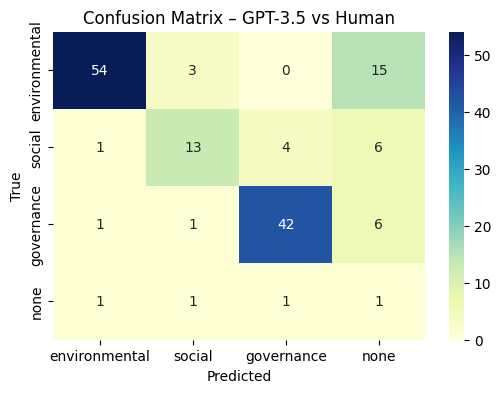

In [ ]:
# Compare GPT-3.5 vs Human Annotations
evaluate_esg(df["esg_label_humain"], df["esg_gpt3"], "GPT-3.5 vs Human")


📊 Accuracy for GPT-3.5 vs ESG-BERT: 70.00%

🧾 Classification Report – GPT-3.5 vs ESG-BERT:

               precision    recall  f1-score   support

environmental       0.96      0.71      0.82        77
   governance       0.74      1.00      0.85        35
         none       0.00      0.00      0.00         0
       social       0.83      0.39      0.54        38

     accuracy                           0.70       150
    macro avg       0.64      0.53      0.55       150
 weighted avg       0.88      0.70      0.76       150



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


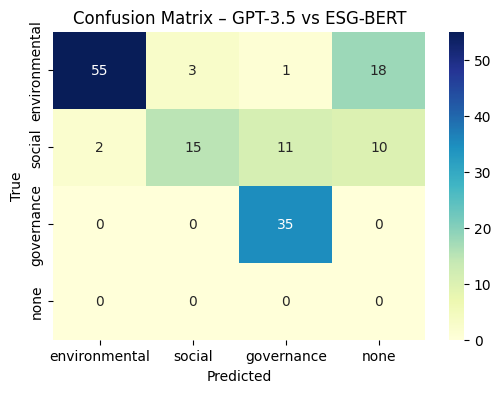

In [ ]:
# Compare GPT-3.5 vs ESG-BERT
evaluate_esg(df["label_dominant"], df["esg_gpt3"], "GPT-3.5 vs ESG-BERT")

In [ ]:
# Show a few misclassified examples (GPT vs Human)
# This helps us understand typical failure cases

print("\n🔍 Misclassified examples (GPT vs Human):")
print(df[df["esg_label_humain"] != df["esg_gpt3"]][["sentence", "esg_label_humain", "esg_gpt3"]].sample(5, random_state=42))


🔍 Misclassified examples (GPT vs Human):
                                              sentence esg_label_humain  \
76   From 1995 to  1997, he ran Pechiney’s Food and...             none   
69   These resources include our new HR Investigati...           social   
67   The HSE Operating Model Our HSE operating mode...           social   
100  The Just Transition Dialogue Report by the Ins...           social   
6    Our compensation programs  are directly linked...       governance   

       esg_gpt3  
76   governance  
69   governance  
67         none  
100        none  
6          none  
